In [1]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime

In [17]:
dataset = h5py.File('simu_HDF_thistimeforReal.h5', 'r') #load data
num_diodes = dataset['Num_diodes'][...] #separate the data into each key within the data file
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
histgrid = histgrid[:-10,:,:] #redefine the shape and size of histgrid by removing the last 10 events
output = np.vstack((x_pos,y_pos)) #define new, single variable for x and y position
output = np.transpose(output) #original definition was sideways, so we transposed it

#values = [117,174,196]
#list of locations (by index) in histgrid which have unusable data due to peaks being in incorrect locations

#new_histgrid = np.delete(histgrid[,:], values, axis=0)
#histgrid = new_histgrid
print(output[0])

where_are_NaNs = isnan(histgrid) #removes any NaN values within histgrid; shouldn't be a problem with 342 removed
histgrid[where_are_NaNs] = 0

print(histgrid.shape)

dataset.close()

[-12. -12.]
(991, 342, 132)


In [3]:
def data_compile(histdata):
    data = []  #creates empty arrays for data and labels
    labels = []
    for i in range(histdata.shape[0]):
        for j in range(1,histdata.shape[2]):
            data.append(histdata[i,0:132,j]) #puts histgrid data inside of "data"
            labels.append(output[i]) #puts xy pos into "labels"
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)

#to make sure everything is the correct shape
print(all_data.shape)
print(all_labels.shape)

(341000, 132)
(341000, 2)


In [ ]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, shuffle=False)
#splits training and test data for the FCNN; 20% set aside for testing

In [19]:
train_data.ndim

2

In [20]:
train_data.shape

(255750, 132)

In [21]:
train_data[0]

array([0.        , 0.        , 0.00372554, 0.        , 0.        ,
       0.        , 0.00372554, 0.        , 0.        , 0.03352984,
       0.11921723, 0.30921968, 0.23470891, 0.2235323 , 0.11921723,
       0.01862769, 0.00372554, 0.00372554, 0.        , 0.00372554,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00372554, 0.        ,
       0.        , 0.        , 0.00372554, 0.00372554, 0.        ,
       0.        , 0.        , 0.00372554, 0.02607877, 0.22725784,
       0.40980922, 0.21980676, 0.01862769, 0.        , 0.00372554,
       0.        , 0.00372554, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00372554, 0.        , 0.        ,
       0.        , 0.00372554, 0.        , 0.        , 0.     

In [22]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [23]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.1))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [24]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [25]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=20,
                    batch_size = 32,
                    #callbacks = [callback],
                    #validation_split = 0.3 
                    )

Epoch 1/20
7993/7993 [==============================] - 29s 4ms/step - loss: 12.0216 - mae: 1.8884 - mse: 12.0216
Epoch 2/20
7993/7993 [==============================] - 26s 3ms/step - loss: 1.6075 - mae: 0.9002 - mse: 1.6075
Epoch 3/20
7993/7993 [==============================] - 31s 4ms/step - loss: 1.1187 - mae: 0.7463 - mse: 1.1187
Epoch 4/20
7993/7993 [==============================] - 30s 4ms/step - loss: 0.9023 - mae: 0.6659 - mse: 0.9023
Epoch 5/20
7993/7993 [==============================] - 32s 4ms/step - loss: 0.7757 - mae: 0.6143 - mse: 0.7757
Epoch 6/20
7993/7993 [==============================] - 31s 4ms/step - loss: 0.6793 - mae: 0.5745 - mse: 0.6793
Epoch 7/20
7993/7993 [==============================] - 33s 4ms/step - loss: 0.6105 - mae: 0.5436 - mse: 0.6105
Epoch 8/20
7993/7993 [==============================] - 33s 4ms/step - loss: 0.5547 - mae: 0.5180 - mse: 0.5547
Epoch 9/20
7993/7993 [==============================] - 33s 4ms/step - loss: 0.5160 - mae: 0.4969 - ms

KeyError: 'val_loss'

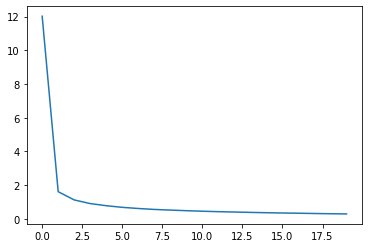

In [26]:
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, RMSprop 0.001, MSE, linear activation")

In [27]:
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2665/2665 - 6s - loss: 602.1862 - mae: 19.1882 - mse: 602.1862


In [28]:
predictions = FCNN_model.predict(test_data)

In [29]:
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = [i[0] for i in test_labels]
y_test1 = [i[1] for i in test_labels]

x_test = np.array(x_test1)
y_test = np.array(y_test1)

x_test[0]
y_test[0]


print(np.min(x_pred))
print(np.min(y_pred))

-38.313416
-40.28475


In [30]:
#to find the locations of largest error within my predicted x values
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = abs(x_pred[i] - x_test[i])
    x_error.append(x_error_test)

error_list_x = [i for i in x_error if i >= 3]
error_list_x.sort(reverse = True)
print(len(error_list_x))
print(error_list_x)

#plt.axis([0, 60000, 0, 5])
#plt.plot(x_error)

84695
[78.31341552734375, 77.55731964111328, 77.24523544311523, 77.03399276733398, 77.01618957519531, 76.98459243774414, 76.97209930419922, 76.93856811523438, 76.86724090576172, 76.85799407958984, 76.82839965820312, 76.808349609375, 76.80819702148438, 76.73501586914062, 76.72450256347656, 76.72367858886719, 76.70523071289062, 76.67464447021484, 76.67012786865234, 76.65851593017578, 76.65217590332031, 76.65185546875, 76.64666748046875, 76.63902282714844, 76.6387710571289, 76.6065444946289, 76.60321044921875, 76.60200119018555, 76.59391021728516, 76.57906341552734, 76.57854461669922, 76.56970596313477, 76.56890106201172, 76.54576873779297, 76.54570007324219, 76.54568481445312, 76.53299713134766, 76.53248596191406, 76.52873229980469, 76.52302551269531, 76.51919174194336, 76.51638412475586, 76.51556777954102, 76.51029205322266, 76.50977325439453, 76.50796127319336, 76.50373840332031, 76.50267028808594, 76.49726486206055, 76.49610900878906, 76.49371337890625, 76.48800659179688, 76.476665496

In [31]:
location = []
for i in error_list_x:
    x_locat = np.where(x_pos == (np.array(x_test[x_error.index(i)])))
    y_locat = np.where(y_pos == (np.array(y_test[x_error.index(i)])))
    locat = np.intersect1d(x_locat, y_locat)
    for l in locat:
        location += l
        
    location.sort()
    #print(location)

KeyboardInterrupt: 

In [65]:
#in "bad value" plug in error value to find the index for x_pos and y_pos
bad_value = 20.54350471496582
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_value)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_value)])))

print(np.intersect1d(x_locat, y_locat))

#the common value between the x and y arrays is the index of the bad data

[309]


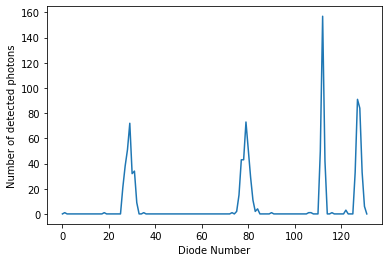

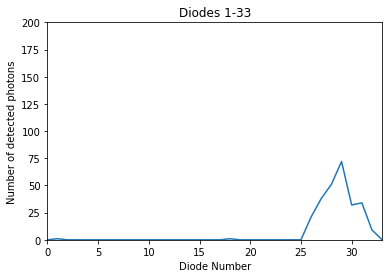

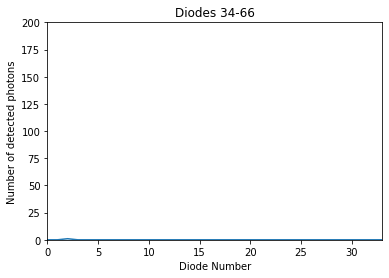

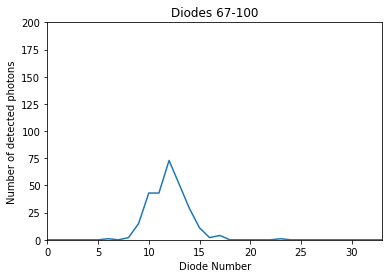

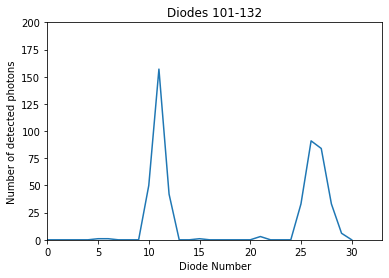

In [98]:
#bad_locat is the index location of the bad data (integer between 0 and 341)
bad_locat = 80

#test_data_value is from 0 to 1000; pick one of the 1001 simulated events for that location
#bad data could appear at any of these, given the bad index
test_data_value = 500

test_histogram = []
for i in range(132):
    test_histogram.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram)

#plt.axis([0, 132, 0, 160])
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.plot(test_histogram)
plt.show()

test_histogram1 = []
for i in range(34):
    test_histogram1.append(histgrid[bad_locat][i][test_data_value])  
np.array(test_histogram1)
 
plt.title('Diodes 1-33')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram1)
plt.show()

test_histogram2 = []
for i in range(33,67):
    test_histogram2.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram2)

plt.title('Diodes 34-66')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram2)
plt.show()

test_histogram3 = []
for i in range(67,101):
    test_histogram3.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram3)

plt.title('Diodes 67-100')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram3)
plt.show()

test_histogram4 = []
for i in range(101,132):
    test_histogram4.append(histgrid[bad_locat][i][test_data_value])    
np.array(test_histogram4)

plt.title('Diodes 101-132')
plt.xlabel('Diode Number')
plt.ylabel('Number of detected photons')
plt.axis([0, 33, 0, 200])
plt.plot(test_histogram4)
plt.show()